In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1
True


In [62]:
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torchvision.models as models
import cv2
import numpy as np 

In [78]:
def extract_plate(image):
    """
    Détecte et recadre la plus grande assiette tout en réduisant l’impact des ombres et reflets.
    """
    if image.mode != "RGB":
        image = image.convert("RGB")

    img_np = np.array(image)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    
    # Appliquer un flou pour réduire le bruit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Détection des cercles (assiettes)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
                               param1=100, param2=30, minRadius=50, maxRadius=200)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        x, y, r = circles[0, 0]  # Prend le premier cercle détecté

        # Ajouter une marge de 10% autour du cercle
        margin = int(r * 0.2)
        x1, y1 = max(0, x - r - margin), max(0, y - r - margin)
        x2, y2 = min(image.width, x + r + margin), min(image.height, y + r + margin)

        # 🔥 Vérifier que les dimensions sont valides
        if x2 > x1 and y2 > y1:
            cropped = image.crop((x1, y1, x2, y2))
            return cropped
        else:
            return image  # Retourne l'image originale si le recadrage est invalide

    # 🔥 Retourne l'image originale si aucun cercle n'est détecté
    return image

In [79]:
def enhance_details(image):
    """
    Applique un filtre Laplacien pour améliorer les détails des assiettes.
    """
    img_np = np.array(image, dtype=np.uint8)

    # Vérifier si l'image a bien 3 canaux, sinon convertir
    if len(img_np.shape) == 2 or img_np.shape[2] == 1:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)  

    # Convertir en niveaux de gris
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    # Appliquer un filtre Laplacien
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    abs_laplacian = np.absolute(laplacian)
    enhanced = np.uint8(abs_laplacian)

    # Convertir en image PIL et revenir en RGB
    enhanced_image = Image.fromarray(enhanced).convert("RGB")
    return enhanced_image

In [80]:
def show_transformed_image(dataset, index=0):
    # Charger l'image originale
    original_path = dataset.dataset.samples[index][0]  
    original_image = Image.open(original_path).convert("RGB")  

    extracted_image = extract_plate(original_image)
    enhanced_image = enhance_details(extracted_image)

    # Appliquer les transformations PyTorch
    transformed_tensor = train_transform(enhanced_image)  
    transformed_image = transformed_tensor.permute(1, 2, 0).numpy()

    # Restaurer la normalisation pour affichage
    mean = np.array([0.5])
    std = np.array([0.5])
    transformed_image = transformed_image * std + mean  
    transformed_image = np.clip(transformed_image, 0, 1)

    # Déterminer si l'image finale est en niveaux de gris ou en RGB
    cmap = "gray" if transformed_tensor.shape[0] == 1 else None

    # Affichage des images
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(original_image)
    axes[0].axis("off")
    axes[0].set_title("1️⃣ Image Originale")

    axes[1].imshow(extracted_image)
    axes[1].axis("off")
    axes[1].set_title("2️⃣ Après Extraction Assiette")

    axes[2].imshow(enhanced_image, cmap="gray")  # Forcer niveaux de gris
    axes[2].axis("off")
    axes[2].set_title("3️⃣ Après Renforcement Détails")

    axes[3].imshow(transformed_image, cmap=cmap)  # Détection automatique du mode
    axes[3].axis("off")
    axes[3].set_title("4️⃣ Image Modèle (Transformée)")

    plt.show()


In [81]:
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: extract_plate(img)),
    transforms.Lambda(lambda img: enhance_details(img)),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Lambda(lambda img: extract_plate(img)),
    transforms.Lambda(lambda img: enhance_details(img)),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [82]:
#Chargement des données d'entrainement + séparation en train et validation car le dossier test n'a pas de label.
full_train_data = datasets.ImageFolder(root="plates/train", transform=train_transform)

train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_data, val_data = random_split(full_train_data, [train_size, val_size])

val_data.dataset.transform = val_test_transform
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)

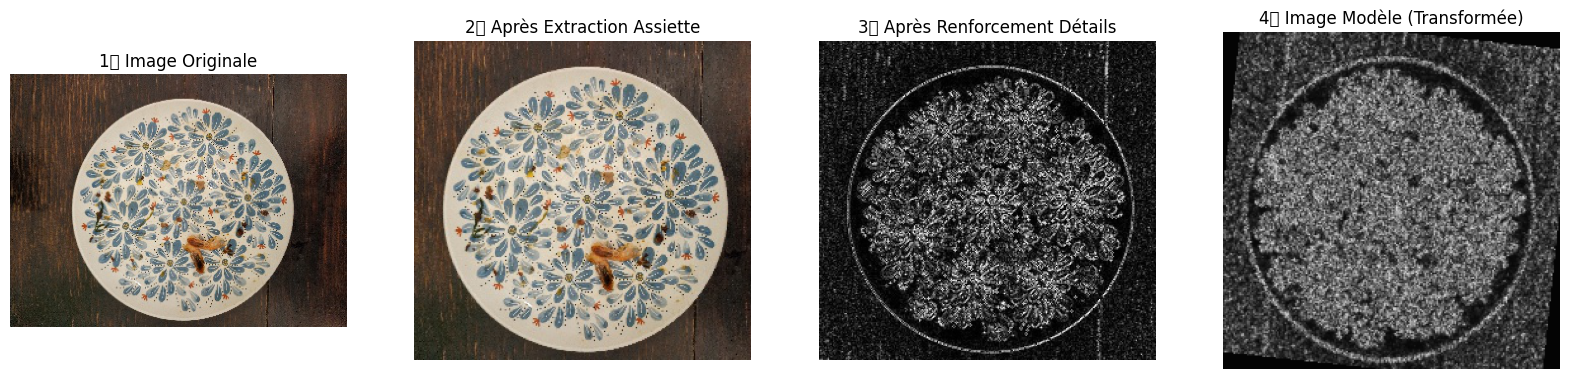

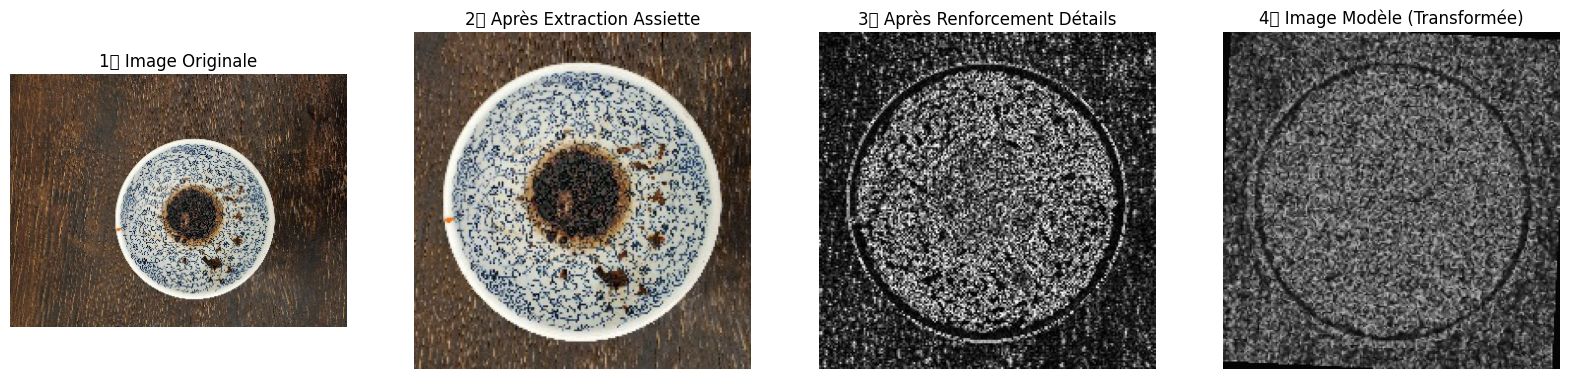

C:\Users\bodin\AppData\Local\Temp\ipykernel_19628\2195181255.py:24: RuntimeWarning: overflow encountered in scalar subtract
  x1, y1 = max(0, x - r - margin), max(0, y - r - margin)


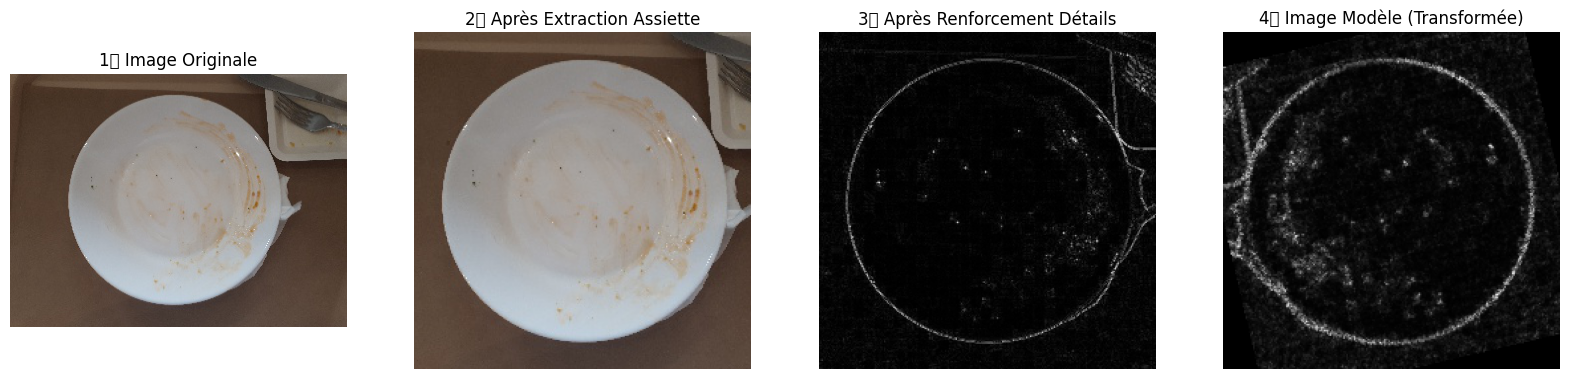

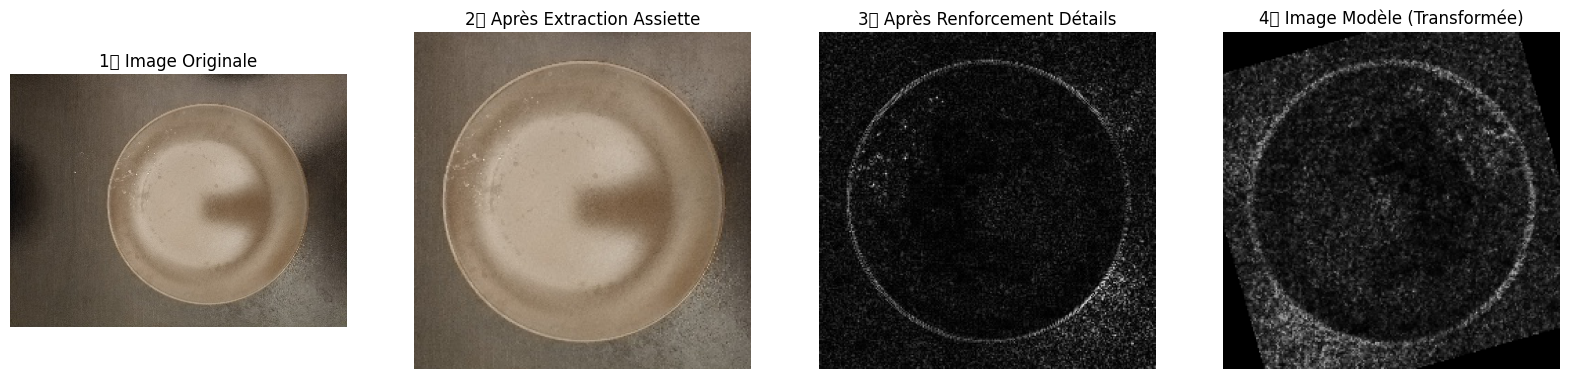

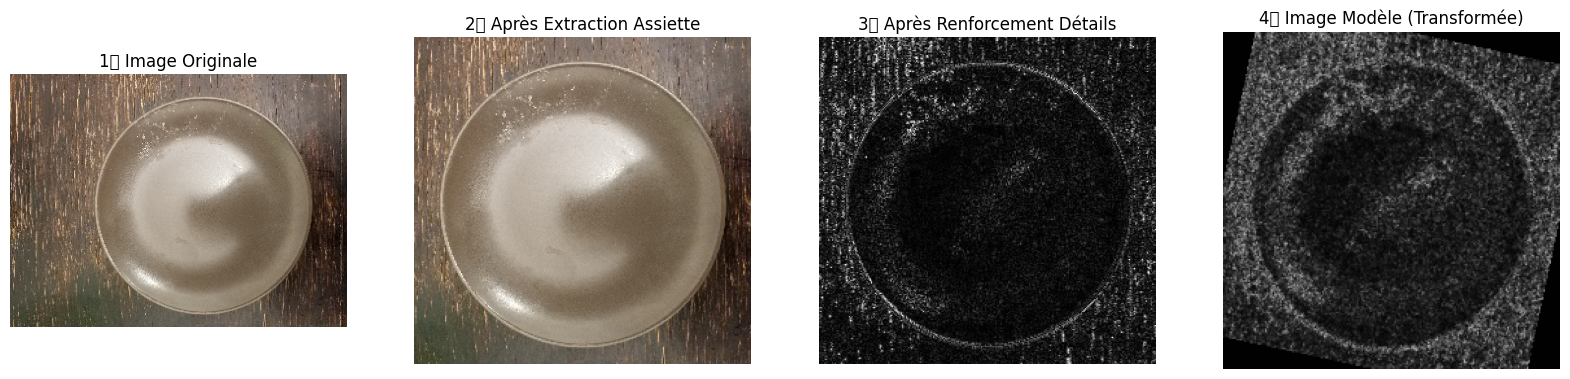

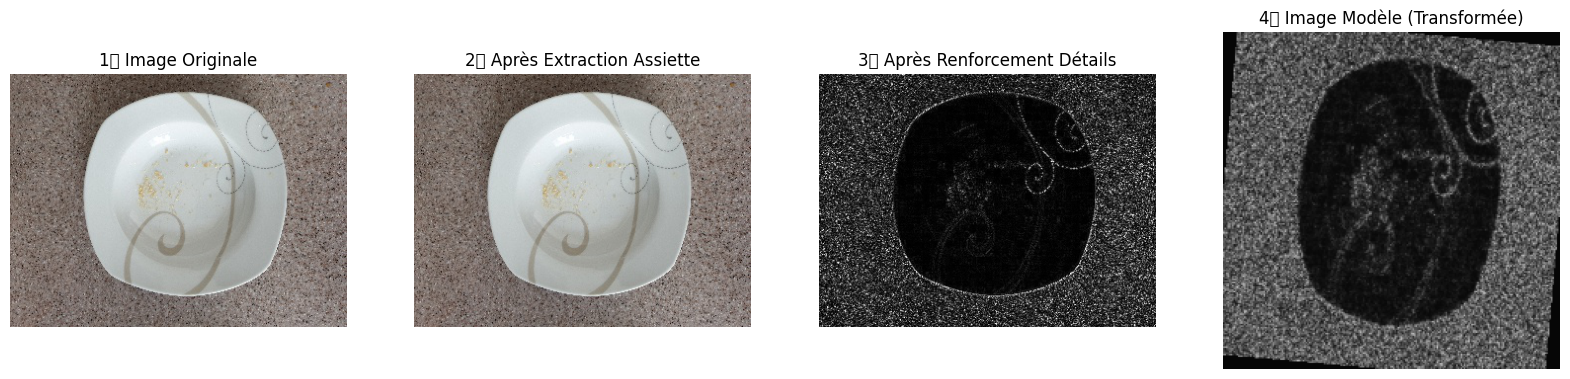

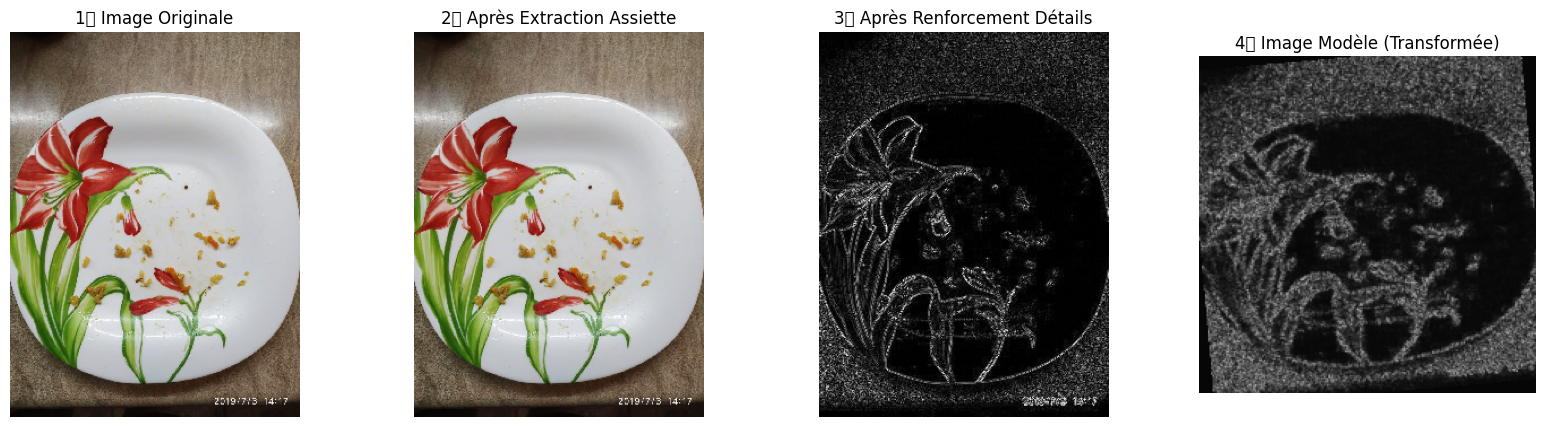

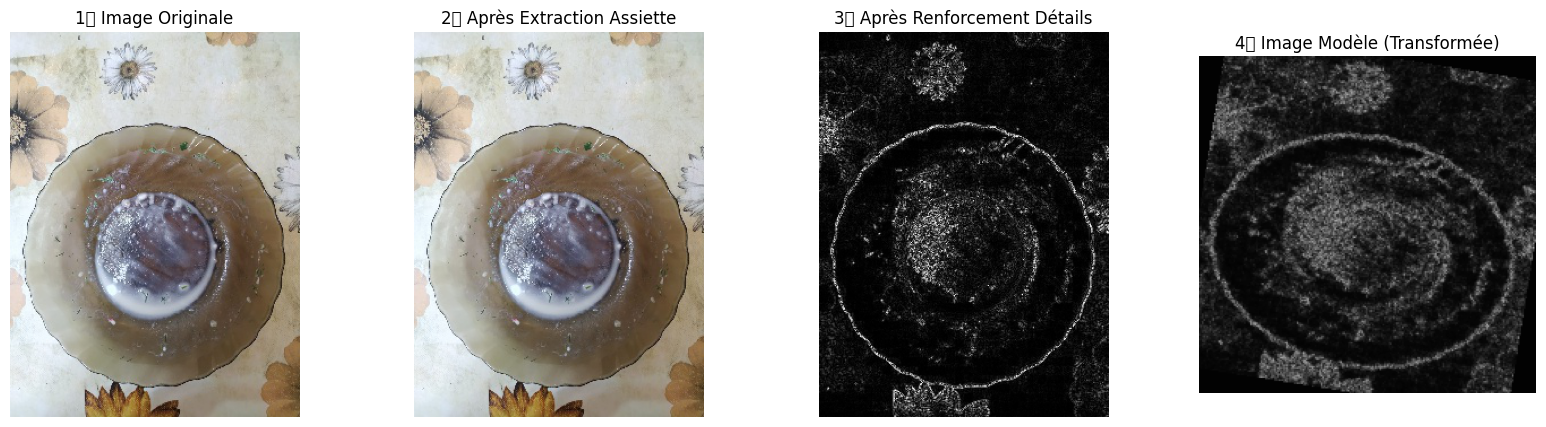

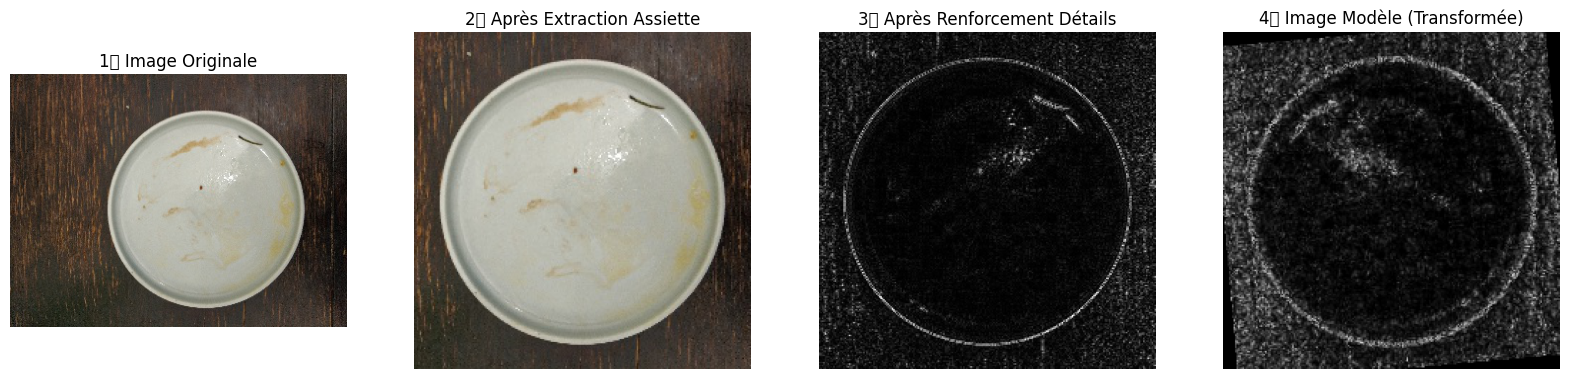

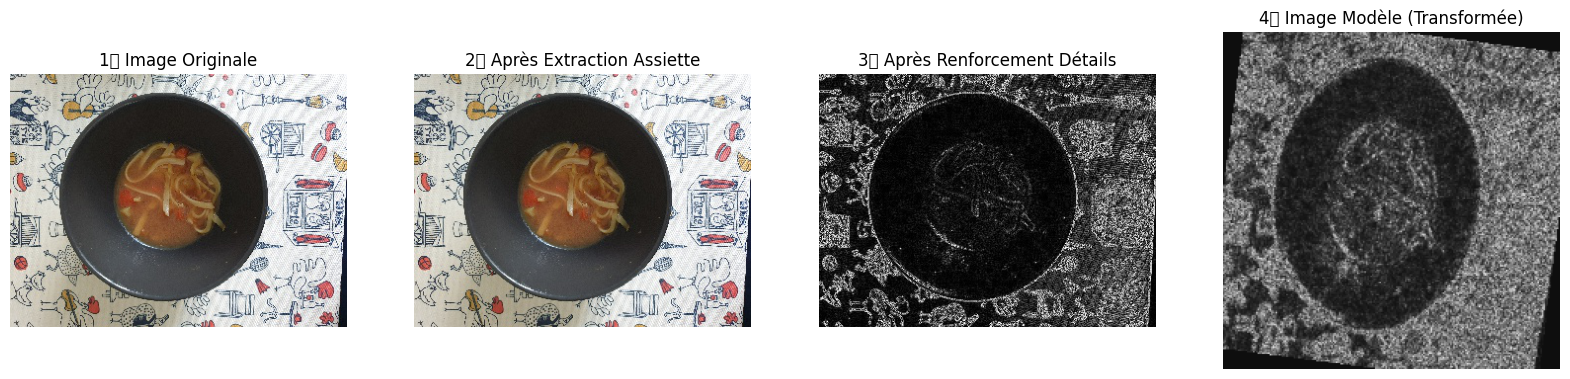

In [83]:
for i in range(20,30):
    show_transformed_image(train_data,index = i)

In [84]:
#création d'une classe spécial pour les images de test, car il n'y a pas les labels.
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_paths = sorted([
            f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]) 

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.test_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx] 
    
    
test_data = TestDataset(test_dir="plates/test", transform=val_test_transform)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

In [85]:
print(f"Total images de train : {len(full_train_data)}")
print(f"Images d'entraînement : {len(train_data)}")
print(f"Images de validation : {len(val_data)}")
print(f"Images de test : {len(test_data)}")

Total images de train : 40
Images d'entraînement : 32
Images de validation : 8
Images de test : 744


In [86]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False 

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1) 

for param in model.fc.parameters():
    param.requires_grad = True 

In [87]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [88]:
#Fonction pour tracer les courbes d'entraînement
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    #Courbe de Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Val Loss", marker="o")
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title("Évolution de la Loss")
    plt.legend()

    #Courbe d'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(epochs, val_accuracies, label="Val Accuracy", marker="o")
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Évolution de l'Accuracy")
    plt.legend()

    plt.show()


In [89]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device=device):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [],[]
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = torch.sigmoid(outputs) >= 0.5
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(100 * correct / total)
        
        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device).view(-1, 1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.sigmoid(outputs) >= 0.5
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)
        
        print(f"Époch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_accuracies[-1]:.2f}% - Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_accuracies[-1]:.2f}%")
    
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

C:\Users\bodin\AppData\Local\Temp\ipykernel_19628\2195181255.py:24: RuntimeWarning: overflow encountered in scalar subtract
  x1, y1 = max(0, x - r - margin), max(0, y - r - margin)


Époch 1/30 - Train Loss: 0.6999 - Train Acc: 43.75% - Val Loss: 0.6340 - Val Acc: 75.00%
Époch 2/30 - Train Loss: 0.6535 - Train Acc: 71.88% - Val Loss: 0.6170 - Val Acc: 62.50%
Époch 3/30 - Train Loss: 0.6450 - Train Acc: 65.62% - Val Loss: 0.6037 - Val Acc: 62.50%
Époch 4/30 - Train Loss: 0.6423 - Train Acc: 59.38% - Val Loss: 0.6452 - Val Acc: 75.00%
Époch 5/30 - Train Loss: 0.6125 - Train Acc: 68.75% - Val Loss: 0.6651 - Val Acc: 62.50%
Époch 6/30 - Train Loss: 0.6501 - Train Acc: 65.62% - Val Loss: 0.6529 - Val Acc: 37.50%
Époch 7/30 - Train Loss: 0.5898 - Train Acc: 71.88% - Val Loss: 0.6701 - Val Acc: 37.50%
Époch 8/30 - Train Loss: 0.6218 - Train Acc: 71.88% - Val Loss: 0.6687 - Val Acc: 37.50%
Époch 9/30 - Train Loss: 0.5523 - Train Acc: 84.38% - Val Loss: 0.6895 - Val Acc: 50.00%
Époch 10/30 - Train Loss: 0.6079 - Train Acc: 75.00% - Val Loss: 0.6785 - Val Acc: 62.50%
Époch 11/30 - Train Loss: 0.5819 - Train Acc: 75.00% - Val Loss: 0.6349 - Val Acc: 62.50%
Époch 12/30 - Train

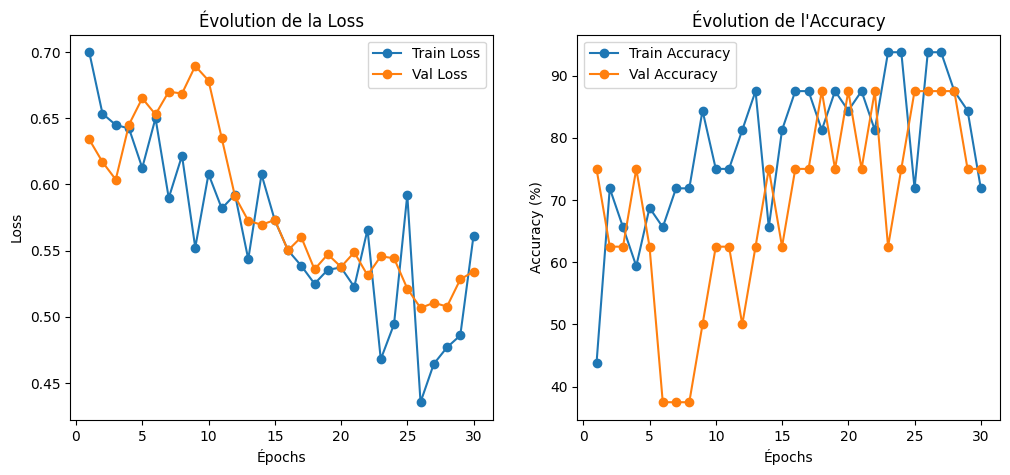

In [90]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

#Training
num_epochs = 30
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [91]:
#predictions sur les images de test
model.eval()
predictions = []
with torch.no_grad():
    for images, image_names in test_loader:
        images = images.to(device)
        outputs = model(images)
        predicted_labels = (torch.sigmoid(outputs) >= 0.5).cpu().numpy().flatten()
        predicted_labels = ["dirty" if pred else "cleaned" for pred in predicted_labels]
        for name, label in zip(image_names, predicted_labels):
            image_id = name.split('.')[0]
            predictions.append([image_id, label])

C:\Users\bodin\AppData\Local\Temp\ipykernel_19628\2195181255.py:24: RuntimeWarning: overflow encountered in scalar subtract
  x1, y1 = max(0, x - r - margin), max(0, y - r - margin)


In [92]:
#création du fichier de submission
submission_df = pd.DataFrame(predictions, columns=["id", "label"])
submission_df.to_csv("submission.csv", index=False)